## SET-NET Birth Defects NLP Python Code: Jupyter Notebook

Authors: Suzy Newton, Nicki Roth, Amy Board \
Last Updated: 03/31/2023 \
Purpose: To classify free text fields for birth defects into overarching categories for analysis \
\
This notebook will guide you through the steps for conducting text cleaning and classification of the bg_icd and bg_icd_sp fields. For additional guidance and a more in-depth overview of our approach to the classification process, please review the SOP for NLP for Birth Defects saved in this folder: \\cdc.gov\locker\NCBDDD_SET_NET\SET-NET_Internal\05_SET_NET_Data\04_Data_Prep\DSU.

## Libraries and setup

Before running the cell below, make sure that you have installed the packages using the Anaconda command prompt. If you do not have Anaconda installed, you may download it here: https://www.anaconda.com/products/distribution. \
\
When running the cell below, you may get the following warning message: 'UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning.' You can ignore this message--it's in reference to the fuzzy matching process function we'll use later on, and it's just warning you that the fuzzy match might take a little while to run.

In [1]:
import pandas as pd
import numpy as np
import os
import re
import sys
import string
import seaborn as sns
import matplotlib.pyplot as plt


# text processing and NLP
import nltk
import sklearn
from nltk.tokenize import RegexpTokenizer,sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# fuzzy matching
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# So all output comes through from Ipython
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set the max number of rows to print out so the notebook is easier to read and navigate
# You can increase this beyond 20 if you want
pd.options.display.max_rows = 20

#Connecting to the SQL server
from sqlalchemy.engine import URL
from sqlalchemy import create_engine

C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Check your working directory

Your working directory should point to wherever you cloned this GitHub repo. You can check your working directory like so:

In [2]:
# Working Directory
print(os.getcwd())

C:\Users\tzf7\Desktop\Analyses


In [3]:
# Set Working Directory (if needed)
## os.chdir("[GITHUB-REPO-LOCATION-HERE]") 

In [4]:
# Confirm it changed the working Directory
print("My working directory:\n" + os.getcwd())

My working directory:
C:\Users\tzf7\Desktop\Analyses


## Import the dummy data file

The NLP folder in this GitHub Repo contains a file of dummy data that can be used for learning purposes. If you are using this code with other data, you may need to clean and transform your dataset so it matches this format.

In [5]:
data = pd.read_excel('synthetic_data.xlsx')

data=data[['ID', 'bg_icd', 'bg_icd_sp']] #extra step to remove temporary notes columns

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1000 non-null   int64 
 1   bg_icd     876 non-null    object
 2   bg_icd_sp  876 non-null    object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


,ID,bg_icd,bg_icd_sp
0,80,Q65.89,Congenital dysplasia of the hip
1,2,M95.2,"Head, molding noted."
2,3,751610,Mesothelial liver cyst
3,4,753410,Right duplex kidney
4,916,Q00.0,NaN


## Import and clean the ICD code reference list

Now we need to import and clean the ICD code reference list so that we can match ICD codes and text data from the POB file and classify them accordingly. Be sure to update the file directory and/or filename as needed in the step below to make sure that the most current, up-to-date reference list is being pulled in.

In [6]:
q = pd.read_excel('SETNET_birthdefects_codes_inclusion_forGitHub.xlsx')

q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ICD            924 non-null    object 
 1   Mod_ICD9_low   137 non-null    float64
 2   Mod_ICD9_high  137 non-null    float64
 3   Text           924 non-null    object 
 4   Category       924 non-null    object 
dtypes: float64(2), object(3)
memory usage: 36.2+ KB


In [7]:
# Display the first 5 observations in the reference list
# Check against the excel spreadsheet to ensure that everything looks correct

q.head()

,ICD,Mod_ICD9_low,Mod_ICD9_high,Text,Category
0,Q00,NaN,NaN,Anencephaly and similar malformations,Congenital malformations of the nervous system
1,Q00.0,740000.0,740109.0,Anencephaly,Congenital malformations of the nervous system
2,Q00.1,NaN,NaN,Craniorachischisis,Congenital malformations of the nervous system
3,Q00.2,NaN,NaN,Iniencephaly,Congenital malformations of the nervous system
4,Q01,742000.0,742099.0,Encephalocele,Congenital malformations of the nervous system


In [8]:
# Count the number of categories in the reference list
# The resulting number should be 13 (1 more category will be added in later steps)

q['Category'].nunique()

12

In [9]:
# remove periods and any other characters that might have been mistakenly added to the ICD code field
remove = ['.',' ',',',';',':','_','?','!','(',')']

for i in remove:
    q['ICD'] = q['ICD'].str.replace(i,'',regex=True)


q

,ICD,Mod_ICD9_low,Mod_ICD9_high,Text,Category
0,Q00,NaN,NaN,Anencephaly and similar malformations,Congenital malformations of the nervous system
1,Q000,740000.0,740109.0,Anencephaly,Congenital malformations of the nervous system
2,Q001,NaN,NaN,Craniorachischisis,Congenital malformations of the nervous system
3,Q002,NaN,NaN,Iniencephaly,Congenital malformations of the nervous system
4,Q01,742000.0,742099.0,Encephalocele,Congenital malformations of the nervous system
...,...,...,...,...,...
919,Q990,NaN,NaN,"Chimera 46, XX/46, XY","Chromosomal abnormalities, not elsewhere class..."
920,Q991,NaN,NaN,"46, XX true hermaphrodite","Chromosomal abnormalities, not elsewhere class..."
921,Q992,NaN,NaN,Fragile X chromosome,"Chromosomal abnormalities, not elsewhere class..."
922,Q998,NaN,NaN,Other specified chromosome abnormalities,"Chromosomal abnormalities, not elsewhere class..."


## Explore and modify the POB data

The steps below provide insight into the basic data structure, data types, and data composition. They also clean the bg_icd and bg_icd_sp codes in preparation for matching to the reference list.

In [10]:
# Identify the number of null values in each column
# If there are null (NaN) values in the columns, they will interfere with our analyses

data.isnull().sum()

ID             0
bg_icd       124
bg_icd_sp    124
dtype: int64

In [11]:
# Count the number of unique ICD-10 codes

data['bg_icd'].nunique()

372

In [12]:
# Get a list of all unique ICD-10 codes in the dataset
# A quick look at this list will inform whether additional cleaning steps need to be added to the steps below

print(data.bg_icd.unique().tolist())

[' Q65.89', 'M95.2', '751610', '753410', 'Q00.0', 'Q000', nan, '756710', 'Q012', 'Q02', '742100', 'Q04.0', 'P520', 'Q04.3', '743202', 'Q04.6', 'D709', 'Q04.8', 'Q046', 'D7282', 'Q048', '749201', 'P358', 'Q05.9', '751490', 'Q07.01', 'Q0703', 'Q10.5', 'Q10.6', 'Q105', 'Q120', 'Q16.1', 'L91.8', 'Q165', 'E872', 'Q17.0', 'Q17.4', 'Q17.9', 'Q170', 'Q172', 'Q18.1', '749090', 'Q18.3', 'Q181', 'Q203', 'Q204', 'D18.1', 'Q21', 'Q21. 0', 'Q21.0', 'P29.3', 'F88', 'D22.5', 'Q21.1', '750600', '744214', '741843', 'Q21.2', '749190', 'Q21.3', 'Q210', '758.700', 'O35.8XX0', 'E2740', 'Q211', 'P362', 'L73.8', 'P70.0', 'P29.12', '745.490', '758200', '756190', 'N48.82', 'H02.53', 'P021', '753600', 'Q212', 'Q213', 'Q22.0', 'Q22.1', 'Q22.5', 'Q22.8', 'Q220', '752605', 'Q221', 'Q222', 'Q228', 'Q23.0', 'P521', 'Q23.1', 'Q23.4', 'E806', '753.302', 'Q231', 'Q232', '749070', 'Q233', '744810', '747190', 'Q234', 'Q24.5', 'Q24.8', '752600', 'Q24.9', 'Q248', 'P90', 'Q25. 0', 'Q25.0', 'ICD 10: Q21.3', 'Q25.1', 'Q25.29',

The cell below conducts basic cleaning on the bg_icd field to match to the Q codes in the reference list. With each new quarterly data import, check to see if any additional cleaning steps are needed, such as additional punctuation or other values that don't belong. \
\
The goal is to match as many ICD codes to the reference list as possible, since the remaining text cleaning and matching processes are more prone to error and misclassification.

In [13]:
# set all codes to uppercase and drop any weird characters from field
data['ICD'] = data['bg_icd'].str.upper() 
remove = ['.',' ',',',';',':','_','?','!','(',')','[',']']


for i in remove:
    data['ICD'] = data['ICD'].str.replace(i,'',regex=True)

data['ICD'] = data['ICD'].replace("NONEREPORTED",np.NaN)

data[['ID','ICD','bg_icd','bg_icd_sp']]

,ID,ICD,bg_icd,bg_icd_sp
0,80,Q6589,Q65.89,Congenital dysplasia of the hip
1,2,M952,M95.2,"Head, molding noted."
2,3,751610,751610,Mesothelial liver cyst
3,4,753410,753410,Right duplex kidney
4,916,Q000,Q00.0,NaN
...,...,...,...,...
995,59,Q985,Q98.5,XYY chromosomes
996,997,756700,756700,Ruptured omphalocele
997,74,Q99,Q99,Suspected Chromosomal Disorder - Karotype Pending
998,246,Q99,Q99,Suspected Chromosomal Disorder - Karotype Pending


In [14]:
#Restrict the newly cleaned dataset to only those observations that do not have missing ICD or bg_icd_sp

data_new = data.loc[(data['ICD'].notnull()) & (data['ICD'] != "") | (data['bg_icd_sp'].notnull()), :].reset_index().copy()
data_new
data_new.info()

,index,ID,bg_icd,bg_icd_sp,ICD
0,0,80,Q65.89,Congenital dysplasia of the hip,Q6589
1,1,2,M95.2,"Head, molding noted.",M952
2,2,3,751610,Mesothelial liver cyst,751610
3,3,4,753410,Right duplex kidney,753410
4,4,916,Q00.0,NaN,Q000
...,...,...,...,...,...
995,995,59,Q98.5,XYY chromosomes,Q985
996,996,997,756700,Ruptured omphalocele,756700
997,997,74,Q99,Suspected Chromosomal Disorder - Karotype Pending,Q99
998,998,246,Q99,Suspected Chromosomal Disorder - Karotype Pending,Q99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      1000 non-null   int64 
 1   ID         1000 non-null   int64 
 2   bg_icd     876 non-null    object
 3   bg_icd_sp  876 non-null    object
 4   ICD        876 non-null    object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [15]:
data_new.isnull().sum()

index          0
ID             0
bg_icd       124
bg_icd_sp    124
ICD          124
dtype: int64

## Clean bg_icd_sp text

Standardize and clean this text to be able to merge with reference text spreadsheet, and for hardcoding below.

In [16]:
#Clean and turn text into a string
remove = ['.',',',';',':','_','?','!','(',')','#']

data_text = data_new.copy()
for i in remove:
    data_text['bg_icd_sp'] = data_text['bg_icd_sp'].str.replace(i,'', regex=True)
    
text = list(data_text['bg_icd_sp'])

A significant number of observations are coming in as camel case text (for example: HeartDisease). We discovered that camel case interferes with the fuzzy matching process and results in a lower similarity index that might otherwise cause us to throw out a true match. The step below fixes the camel case text by adding a space in between text with a lowercase letter followed immediately by an uppercase letter and then makes all text values lowercase.

In [17]:
#Fix camel case text
text_new=[]

for i in text:
    i = str(i)
    a = re.sub(r'((?<=[a-z])[A-Z]|(?<!\A)[A-Z](?=[a-z]))', r' \1',i).lower()
    text_new.append(a)

Now that the text has been cleaned and standardized, we will merge the cleaned bg_icd_sp field back into the pob3 dataframe so we can use this later when we merge with the ICD text reference spreadsheet and when we perform the NLP steps.

In [18]:
#Merge the clean text field back into merged_dta for later use with NLP
bg_icd_sp_clean = pd.DataFrame(text_new, columns = ['bg_icd_sp_clean']).reset_index()

data_clean = pd.merge(data_new, bg_icd_sp_clean, left_index=True, right_index=True)
data_clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
data_clean['ICD'] = data_clean['ICD'].astype(str)

#Drop old columns
data_clean=data_clean.drop(['bg_icd','bg_icd_sp'], axis=1) #'level_0'], axis=1) #removing level_0 from drop
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               1000 non-null   int64 
 1   ICD              1000 non-null   object
 2   bg_icd_sp_clean  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


## Merge POB data to Q code reference list

Now that the ICD codes have been cleaned and we've set those we can based on their reviewed text, we can merge the POB data and the reference list together.

In [19]:
merged = data_clean.merge(q, how='left', on='ICD')

merged.info()

# View NaN values in Category in the resulting merged dataset
pd.set_option('display.max_rows', None)
merged[merged["Category"].isnull()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               1000 non-null   int64  
 1   ICD              1000 non-null   object 
 2   bg_icd_sp_clean  1000 non-null   object 
 3   Mod_ICD9_low     149 non-null    float64
 4   Mod_ICD9_high    149 non-null    float64
 5   Text             684 non-null    object 
 6   Category         684 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 62.5+ KB


,ID,ICD,bg_icd_sp_clean,Mod_ICD9_low,Mod_ICD9_high,Text,Category
1,2,M952,head molding noted,NaN,NaN,NaN,NaN
2,3,751610,mesothelial liver cyst,NaN,NaN,NaN,NaN
3,4,753410,right duplex kidney,NaN,NaN,NaN,NaN
6,7,nan,small apical anterior muscular ventricular sep...,NaN,NaN,NaN,NaN
7,8,756710,gastroschisis,NaN,NaN,NaN,NaN
13,14,742100,microcephaly,NaN,NaN,NaN,NaN
15,16,756710,gastroschisis,NaN,NaN,NaN,NaN
16,17,P520,intraventricular hemorrhage grade 1 of newborn,NaN,NaN,NaN,NaN
20,21,743202,congenital glaucoma right eye,NaN,NaN,NaN,NaN
22,23,D709,neutropenia unspecified,NaN,NaN,NaN,NaN


In [20]:
# Check that the shape of the resulting dataset meets expectations (e.g., number of columns, number of rows)
merged.shape

# Run a quick summary of numbers of observations in each category
merged.groupby('Category').count().sort_values('Text',ascending=False)

(1000, 7)

,ID,ICD,bg_icd_sp_clean,Mod_ICD9_low,Mod_ICD9_high,Text
Category,,,,,,
Not a birth defect of interest/Unable to categorize,296,296,296,4,4,296
Congenital malformations of the circulatory system,137,137,137,109,109,137
Congenital malformations and deformations of the musculoskeletal system,82,82,82,15,15,82
Congenital malformations of genital organs,49,49,49,0,0,49
Congenital malformations of the urinary system,28,28,28,1,1,28
Congenital malformations of the nervous system,25,25,25,6,6,25
Other congenital malformations of the digestive system,20,20,20,4,4,20
"Chromosomal abnormalities, not elsewhere classified",17,17,17,3,3,17
Cleft lip and cleft palate,11,11,11,0,0,11



## Match modified ICD-9 codes

Massachussetts sends modified ICD-9 codes, which are numbers and start with 7 usually. The columns Mod_ICD9_low and	Mod_ICD9_high contain the reference values we will use to match the modified ICD-9 code with the correct birth defect text and category.


In [21]:
#Restrict to Massachussetts rows
MACDP_data = merged.loc[merged['ICD'].str.startswith('7')].copy()

#Convert ICD to numeric
MACDP_data['ICD'] = MACDP_data['ICD'].astype(int)

#Restrict to columns needed
MACDP_data = MACDP_data[['ID','ICD']]
MACDP_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 2 to 996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      79 non-null     int64
 1   ICD     79 non-null     int32
dtypes: int32(1), int64(1)
memory usage: 1.5 KB


In [22]:
#Creating modified ICD-9 dictionary
MACDP = q.loc[q['Mod_ICD9_low'].notnull(), :].copy()
MACDP.head()
#Restrict to columns needed
MACDP = MACDP[['Mod_ICD9_low','Mod_ICD9_high','Text','Category']] 

,ICD,Mod_ICD9_low,Mod_ICD9_high,Text,Category
1,Q000,740000.0,740109.0,Anencephaly,Congenital malformations of the nervous system
4,Q01,742000.0,742099.0,Encephalocele,Congenital malformations of the nervous system
10,Q02,742100.0,742109.0,Microcephaly,Congenital malformations of the nervous system
11,Q020,742286.0,742286.0,Microcephaly,Congenital malformations of the nervous system
12,Q03,742300.0,742399.0,Congenital hydrocephalus,Congenital malformations of the nervous system


In [23]:
#Convert ICD 9 columns to integers
MACDP['Mod_ICD9_low']=MACDP['Mod_ICD9_low'].astype(int)
MACDP['Mod_ICD9_high']=MACDP['Mod_ICD9_high'].astype(int)

In [24]:
#Merge dataframes and assign text and category for each row in MAS
MACDP_data_assigned = MACDP_data.assign(key=1).merge(MACDP.assign(key=1), on='key')\
                 .drop(columns='key')\
                 .query('ICD.between(Mod_ICD9_low, Mod_ICD9_high)')\
                 .drop(columns=['Mod_ICD9_low', 'Mod_ICD9_high'])\
                 .reset_index(drop=True)
MACDP_data_assigned['ICD'] = MACDP_data_assigned['ICD'].astype(str)
MACDP_data_assigned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        72 non-null     int64 
 1   ICD       72 non-null     object
 2   Text      72 non-null     object
 3   Category  72 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.4+ KB


In [25]:
#Merge assigned MAS cases back into full dataframe
merged = merged[['ID','ICD','bg_icd_sp_clean','Text','Category']] 
merged_new= merged.merge(MACDP_data_assigned, how='left', on=['ID','ICD'])

merged_new.head()
merged_new.info()

,ID,ICD,bg_icd_sp_clean,Text_x,Category_x,Text_y,Category_y
0,80,Q6589,congenital dysplasia of the hip,Other specified congenital deformities of hip,Congenital malformations and deformations of t...,NaN,NaN
1,2,M952,head molding noted,NaN,NaN,NaN,NaN
2,3,751610,mesothelial liver cyst,NaN,NaN,Other congenital malformations of pancreas and...,Other congenital malformations of the digestiv...
3,4,753410,right duplex kidney,NaN,NaN,NaN,NaN
4,916,Q000,nan,Anencephaly,Congenital malformations of the nervous system,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               1000 non-null   int64 
 1   ICD              1000 non-null   object
 2   bg_icd_sp_clean  1000 non-null   object
 3   Text_x           684 non-null    object
 4   Category_x       684 non-null    object
 5   Text_y           72 non-null     object
 6   Category_y       72 non-null     object
dtypes: int64(1), object(6)
memory usage: 62.5+ KB


In [26]:
#Replace Text_y column with values from Text_x where Text_y is NaN, and rename Text_y
merged_new['Text'] = merged_new['Text_x'].fillna(merged_new['Text_y'])
merged_new['Category'] = merged_new['Category_x'].fillna(merged_new['Category_y'])

merged_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               1000 non-null   int64 
 1   ICD              1000 non-null   object
 2   bg_icd_sp_clean  1000 non-null   object
 3   Text_x           684 non-null    object
 4   Category_x       684 non-null    object
 5   Text_y           72 non-null     object
 6   Category_y       72 non-null     object
 7   Text             756 non-null    object
 8   Category         756 non-null    object
dtypes: int64(1), object(8)
memory usage: 78.1+ KB


## Hard-code classifications for specific observations

Some ICD codes and text have been incorrectly reported in the bg_icd and bg_icd_sp variables and are not, in fact, birth defects. Others provide too little information to classify, such as test results that are pending. Additionally, some text values occur frequently enough that it's worth hard-coding those observations into their specific categories to ensure the steps above have classified them appropriately and to improve overall accuracy of the NLP model. 

The steps below conduct hard-coding of these classifications in the merged_dta dataframe. With new data submissions, additional hard-coding may be required. Refer to the analyst SOP and clinical review SOP for additional information.

In [27]:
#Drop old columns
merged_clean=merged_new.drop(['Category_x','Category_y','Text_x','Text_y'], axis=1)
merged_clean.shape
merged_clean.head(20)

(1000, 5)

,ID,ICD,bg_icd_sp_clean,Text,Category
0,80,Q6589,congenital dysplasia of the hip,Other specified congenital deformities of hip,Congenital malformations and deformations of t...
1,2,M952,head molding noted,NaN,NaN
2,3,751610,mesothelial liver cyst,Other congenital malformations of pancreas and...,Other congenital malformations of the digestiv...
3,4,753410,right duplex kidney,NaN,NaN
4,916,Q000,nan,Anencephaly,Congenital malformations of the nervous system
5,826,Q000,anencephaly,Anencephaly,Congenital malformations of the nervous system
6,7,nan,small apical anterior muscular ventricular sep...,NaN,NaN
7,8,756710,gastroschisis,Gastroschisis,Congenital malformations and deformations of t...
8,304,Q012,occipital encephalocele,Occipital encephalocele,Congenital malformations of the nervous system
9,57,Q02,nan,Microcephaly,Congenital malformations of the nervous system


Create a separate dataset of all observations with missing ICD code or non-matching ICD codes.

In [28]:
Qmiss = merged_clean.loc[merged_clean['Category'].isnull(), :].copy()
Qmiss.shape

(244, 5)

In [29]:
Qmiss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 1 to 991
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               244 non-null    int64 
 1   ICD              244 non-null    object
 2   bg_icd_sp_clean  244 non-null    object
 3   Text             0 non-null      object
 4   Category         0 non-null      object
dtypes: int64(1), object(4)
memory usage: 11.4+ KB


Now re-classify observations with text that contains the words "pending" or "suspected" as unable to classify, and also re-classify observations with text or ICD codes that indicate something that is not actually a birth defect. Add some additional categories for hard-coding: 1) observations that are not a birth defect based on ICD code (e.g., non-Q codes), and 2) commonly occurring text (or text values that otherwise need to be hard-coded). For more information, see the analytic SOP and clinical review SOP.

In [30]:
# Recoding observations as "Not a birth defect of interest/Unable to classify"
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean']=='other'),'Not a birth defect of interest/Unable to classify',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean']=='other '),'Not a birth defect of interest/Unable to classify',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean']=='a'),'Not a birth defect of interest/Unable to classify',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean']=='other anomaly'),'Not a birth defect of interest/Unable to classify',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean']=='other  anomaly'),'Not a birth defect of interest/Unable to classify',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains("pending")),'Not a birth defect of interest/Unable to classify',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains("suspected")),'Not a birth defect of interest/Unable to classify',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.find("tongue tie",0)>=0),'Not a birth defect of interest/Unable to classify',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('sacral dimple')),'Not a birth defect of interest/Unable to classify',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains("possible")),'Not a birth defect of interest/Unable to classify',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['ICD'].str.contains("Notabirthdefectofinterest/Unabletoclassify")),'Not a birth defect of interest/Unable to classify',Qmiss['Category'])

# Recoding observations as "Not a birth defect" based on text data
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('murmur')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.find("mongolian",0)>=0),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('nevus')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('tachycardia')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('glycemia')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('non-viable fetus')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('small for gestational age')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('large for gestational age')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('caput')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('hernia umbilical')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('umbilical hernia')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('phimosis')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('hydrocele')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('anemia')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('premature infant')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('stillbirth')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['bg_icd_sp_clean'].str.contains('respiratory distress')),'Not a birth defect',Qmiss['Category'])

# Recoding observations as "Not a birth defect" based on ICD code
Qmiss.loc[Qmiss['ICD'].str.contains(r"^[a-pr-zA-PR-Z][0-9]+$", regex=True), 'Category'] = 'Not a birth defect'

Qmiss['Category'] = np.where((Qmiss['ICD'].str.contains('TERMINALMECOMIUN')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['ICD'].str.contains('FORAMENOVULEANEURYSM')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['ICD'].str.contains('VENTRA')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['ICD'].str.contains('ANEMIA')),'Not a birth defect',Qmiss['Category'])
Qmiss['Category'] = np.where((Qmiss['ICD'].str.contains('Notabirthdefect')),'Not a birth defect',Qmiss['Category'])

Qmiss['Category'].value_counts()

Not a birth defect                                   113
Not a birth defect of interest/Unable to classify      5
Name: Category, dtype: int64

Now we can remove these rows that have been hardcoded from Qmiss and will later add them into the NoMiss dataframe

In [31]:
Qmiss2 = Qmiss.loc[Qmiss['Category'].isnull(), :].copy()

Qmiss2.shape

nomiss_new = Qmiss.loc[Qmiss['Category'].notnull(), :].copy()

nomiss_new.shape

(126, 5)

(118, 5)

In [32]:
#Restrict Qmiss to relevant columns
Qmiss2 = Qmiss2[['ID','bg_icd_sp_clean','ICD']]

The reference list of Q codes that we are using is a living document. It represents all Q codes that are currently present within the POB data. With each new data import, we need to manually check the list of nonmatching ICD codes in Qmiss to see if there are any new Q codes that haven't previously been included in the dataset. These codes should be added to the reference list and categorized accordingly based on clinical review.\
\
IMPORTANT: After the new Q codes have been categorized, you must re-run each of the steps above so that the ICD codes in the POB dataset can be matched with the newly-categorized ICD codes. Remember, the more observations we can match on ICD code, the more robust our model will be, and the fewer observations we will have left to try to predict their classifications using NLP.

In [33]:
# Review non-matching Q codes to see if any need to be added to the reference list
Qmiss_review = Qmiss2[Qmiss2['ICD'].astype(str).str.contains('Q')].copy()
Qmiss_review

# If the list is too long to review in the Jupyter notebook, you can export to an excel file using the code below:
##############################Qmiss_review.to_excel('Qmiss_review.xlsx')

,ID,bg_icd_sp_clean,ICD
258,259,congenital heart defect tetralogy of fallot w...,ICD10Q213
691,298,congenital partial dislocation of left hip uni...,Q6532
972,214,marfans syndrome unspecified,Q8740


Create a separate dataset of all observations with matching ICD codes, which we will use to build our NLP model.

In [34]:
nomiss = merged_clean.loc[merged_clean['bg_icd_sp_clean'].notnull() & (merged_clean['Category'].notnull()), :].copy()

nomiss.shape

(756, 5)

In [35]:
nomiss2 = pd.concat([nomiss, nomiss_new])

nomiss2.shape

(874, 5)

Plot the frequencies of observations for each birth defect category in nomiss. This will give us an idea of the number of data elements we are supplying for the model, and indicates that stratified sampling is necessary for the model because our data is highly imbalanced between categories.

[Text(0, 0, 'Not a birth defect of interest/Unable to categorize'),
 Text(1, 0, 'Congenital malformations of the circulatory system'),
 Text(2, 0, 'Not a birth defect'),
 Text(3, 0, 'Congenital malformations and deformations of the musculoskeletal system'),
 Text(4, 0, 'Congenital malformations of genital organs'),
 Text(5, 0, 'Congenital malformations of the urinary system'),
 Text(6, 0, 'Congenital malformations of the nervous system'),
 Text(7, 0, 'Chromosomal abnormalities, not elsewhere classified'),
 Text(8, 0, 'Other congenital malformations of the digestive system'),
 Text(9, 0, 'Cleft lip and cleft palate'),
 Text(10, 0, 'Congenital malformations of eye, ear, face and neck'),
 Text(11, 0, 'Other congenital malformations'),
 Text(12, 0, 'Congenital malformations of the respiratory system'),
 Text(13, 0, 'Not a birth defect of interest/Unable to classify')]

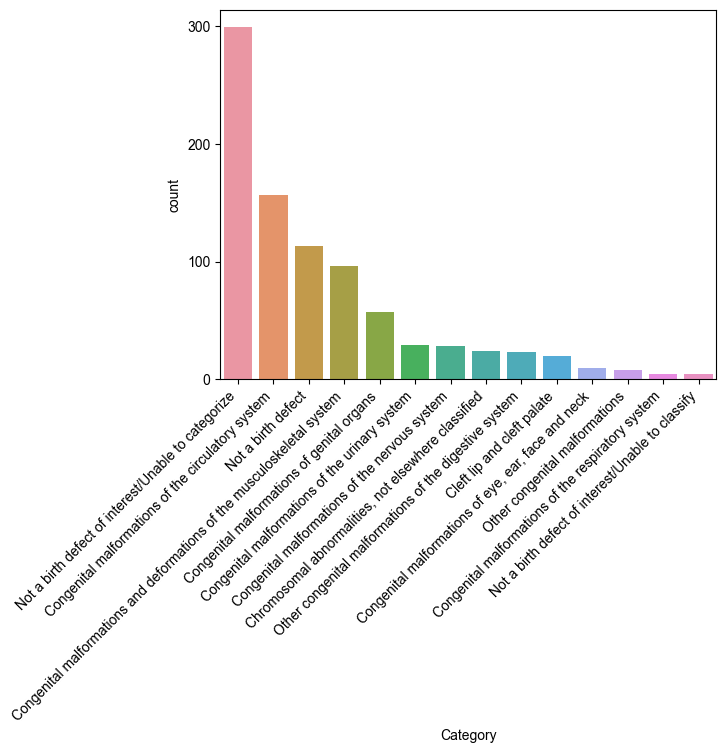

In [36]:
chart = sns.countplot(x=nomiss2['Category'], order=pd.value_counts(nomiss2['Category']).index)
sns.set(rc = {'figure.figsize':(20,5)},font_scale=2)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

## Fuzzy matching: Non-categorized observations

Observations with missing or nonmatching ICD values in Qmiss might have text in bg_icd_sp_clean that matches exactly or very nearly to a Q code ICD description. If we can match some observations through fuzzy matching, we can add those matched values to nomiss, develop a more robust NLP model, and we are left with fewer unclassified observations that we would have to predict using ML.\
\
We will use the fuzzywuzzy package for Python to conduct the fuzzy matching against the ICD code description text in the reference list.

In [37]:
#Turn text from q2 into a list of strings and make all characters lowercase
ref_vals = list(q['Text'].str.lower())
ref_vals

['anencephaly and similar malformations',
 'anencephaly',
 'craniorachischisis',
 'iniencephaly',
 'encephalocele',
 'frontal encephalocele',
 'nasofrontal encephalocele',
 'occipital encephalocele',
 'encephalocele of other sites',
 'encephalocele, unspecified',
 'microcephaly',
 'microcephaly',
 'congenital hydrocephalus',
 'malformations of aqueduct of sylvius',
 'atresia of foramina of magendie and luschka',
 'other congenital hydrocephalus',
 'congenital hydrocephalus, unspecified',
 'other congenital malformations of brain',
 'congenital malformations of corpus callosum',
 'arhinencephaly',
 'holoprosencephaly',
 'other reduction deformities of brain',
 'septo-optic dysplasia of brain',
 'congenital cerebral cysts',
 'other specified congenital malformations of brain',
 'congenital malformation of brain, unspecified',
 'spina bifida',
 'cervical spina bifida with hydrocephalus',
 'thoracic spina bifida with hydrocephalus',
 'lumbar spina bifida with hydrocephalus',
 'sacral spina

In [38]:
#Turn text from Qmiss into a string
unmatched = list(Qmiss2['bg_icd_sp_clean'])
unmatched

['right duplex kidney',
 'small apical anterior muscular ventricular septal defect measuring 2mm with bidirectional shunting',
 'atrial septal defect',
 'ventricular septal defect',
 'ventricular septal defect',
 'ankyloglossia',
 'pfo left to right shunt',
 'trisomy 13 unspecified',
 'polydactyly unspecified',
 'patent ductus arteriosus',
 'gastroschisis',
 'mild hypospadias',
 'buried penis',
 'oth congenital malform of spine not associated w scoliosis',
 'fetal cardiac anomaly affecting pregnancy antepartum',
 'omphalocele',
 'accessory finger',
 'other specified congenital malformations of skin',
 'microcephaly',
 'two small muscular ventricular septal defects',
 'coronal hypospadias and chordee',
 'oth congenital malform of spine not associated w scoliosis',
 'plantar  skin  creases',
 'd- transposition of the great vessels with membranous ventricular septal defect',
 'atrial septal defect',
 'renal agenesis unilateral',
 'double right kidney',
 'klinefelter syndrome karyotype 47x

Use the process function in the fuzzywuzzy package to identify the reference ICD code description value with the closest match to the bg_icd_sp text in Qmiss. The step below prints out the ICD code description that is the closest match to the text field in one row and the similarity index for the match in the following row. We create a for loop that will run each bg_icd_sp value through the entire list of ICD code descriptions from the reference list and put the results into a dataframe.\
\
Note that this step can take a few minutes to run on your computer.

In [39]:
match_results = {'Matched Value':[], 'FW_score':[], 'bg_icd_sp_clean':[]}

highest = process.extractOne(i, ref_vals)

for i in unmatched:
    highest = process.extractOne(i,ref_vals)
    match_results['Matched Value'].append(highest[0])
    match_results['FW_score'].append(highest[1])
    match_results['bg_icd_sp_clean'].append(i)

        
clean_fw_results = pd.DataFrame(match_results)
clean_fw_results

,Matched Value,FW_score,bg_icd_sp_clean
0,double outlet right ventricle,86,right duplex kidney
1,ventricular septal defect,90,small apical anterior muscular ventricular sep...
2,atrial septal defect,100,atrial septal defect
3,ventricular septal defect,100,ventricular septal defect
4,ventricular septal defect,100,ventricular septal defect
5,ankyloglossia,100,ankyloglossia
6,"congenital dislocation of right hip, unilateral",86,pfo left to right shunt
7,"trisomy 13, unspecified",98,trisomy 13 unspecified
8,"polydactyly, unspecified",98,polydactyly unspecified
9,patent ductus arteriosus,100,patent ductus arteriosus


Now that we have the fuzzy matching results lined up nicely to the bg_icd_sp_clean values, we'll merge these results with the original Qmiss dataframe so that these values are linked to participant ID. Note that when you perform the steps below, you may observe that a handful of observations were dropped from the steps above. This is not a mistake! In the current dataset, there are a few IDs that have duplicated bg_icd and bg_icd_sp fields (e.g., the same ICD code and text description repeated twice for the same participant ID in bg_icd1/bg_icd1_sp and bg_icd2/bg_icd2_sp). These are genuine duplicates and should be dropped. If you want to be extra sure, you can export Qmiss to an excel workbook and use the "highlight duplicate values" feature in conditional formatting to do a manual check and ensure it is only true duplicates that are being dropped in the next step.

In [40]:
clean_fw_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Matched Value    126 non-null    object
 1   FW_score         126 non-null    int64 
 2   bg_icd_sp_clean  126 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


In [41]:
#Now combine with original dataframe
miss_fw_matched = pd.merge(Qmiss2, clean_fw_results, how='left', on='bg_icd_sp_clean').drop_duplicates()

miss_fw_matched.rename(columns={'ICD':'ICD_orig'}, inplace = True)
miss_fw_matched.shape

(126, 5)

Now we will merge with the reference dataset on ICD description values so that we have the associated category for the matched values. Note that we will need to drop duplicates again, but this time, it's for another reason. The reference list includes some parent ICD codes that have the same ICD text description as certain child codes (e.g., parent and child codes for cleft lip). When we match the two dataframes on ICD description values, we end up with duplicate values for those observations for all but ICD code, because the text description matches to more than one ICD code. To solve this, we drop all values that have a duplicate ID, bg_icd, bg_icd_sp, and Text field. It doesn't matter which ICD code is retained for those values because all we're interested in ultimately is the Category, and the codes with matching ICD text will be assigned to the same Category of birth defects.

In [42]:
# Merge with reference dataset
qnew = q
qnew['Matched Value'] = q['Text'].str.lower()


miss_fw_matched2 = pd.merge(miss_fw_matched, qnew, how='left', on='Matched Value')

# Drop duplicate observations where ID, bg_icd_sp, and Text are all the same.
miss_fw_matched2 = miss_fw_matched2.drop_duplicates(subset=['ID','bg_icd_sp_clean','Text'])

miss_fw_matched2.shape

(126, 10)

Now you can export this dataframe to an excel document that will allow for clinical review of the fuzzy match results. Currently, our cutoff value is a similarity score of 90% or higher for something to be considered a "true" match. For observations with a cutoff value of 90% or higher, we will assign the associated birth defect category to the matching ICD code and text description. However, as new data submissions come in, you will want to check the results as described in the clinical review SOP to ensure that 90% is still an approporiate cutoff value. Use the step below to export the dataframe, updating the date of the filename accordingly.

In [43]:
# Export an excel file with these results

##############################miss_fw_matched2.to_excel('Fuzzy_Matching_Qmiss_March2023.xlsx')

## Preparing the data for ML

Now that we've done fuzzy matching, we want to update the Qmiss and noMiss dataframes to accommodate these additional values before we develop our NLP model. 

miss_fw_matched2 now has a number of observations that are classified due to a fuzzy match similarity score of 90% or greater or due to hard-coding of observations. We want to extract these observations and add them to nomiss, which will increase the robustness of our training and testing data for NLP. To do this, we will flag all of the observations in Qmiss that have now been accurately classified.

In [44]:
# Pull out values from miss_fw_matched2 that are now classified due to a fuzzy match score of >=90%
# Create a flag variable
miss_fw_matched2['classified_flag'] = np.where((miss_fw_matched2['FW_score'] > 89),1,0)

miss_fw_matched2.shape

(126, 11)

Classified_flag values that equal 1 will be extracted from Qmiss_clean2 and joined to a final version of nomiss to be used to build our NLP model.

In [45]:
# Remove values to be added to Nomiss
miss_fw_matched3 = miss_fw_matched2.loc[miss_fw_matched2['classified_flag']==1].drop(['Matched Value',
                                                                           'FW_score','classified_flag','ICD_orig'],axis='columns').copy()
miss_fw_matched3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 2 to 142
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               91 non-null     int64  
 1   bg_icd_sp_clean  91 non-null     object 
 2   ICD              91 non-null     object 
 3   Mod_ICD9_low     35 non-null     float64
 4   Mod_ICD9_high    35 non-null     float64
 5   Text             91 non-null     object 
 6   Category         91 non-null     object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.7+ KB


In [46]:
# Join with nomiss
nomiss3 = pd.concat([nomiss2, miss_fw_matched3],ignore_index = True)
nomiss3.shape
nomiss3=nomiss3.drop(['Mod_ICD9_low','Mod_ICD9_high'], axis=1)

(965, 7)

Now subset miss_fw_matched2 to only those observations with a classified_flag value of 0. These are the remaining unclassified observations in the dataset that will be classified using NLP.

In [47]:
# Subset to remaining unclassified values for classification using NLP modeling
Qmiss3 = miss_fw_matched2.loc[miss_fw_matched2['classified_flag']==0].drop(
     ['classified_flag','Matched Value','FW_score','Category','ICD', 'Text','Mod_ICD9_low','Mod_ICD9_high'],axis='columns').reset_index().copy()
Qmiss3.rename(columns={'ICD_orig':'ICD'}, inplace = True)
Qmiss3.shape

(35, 4)

# Now it's time for some NLP!

We will build our NLP classification model using nomiss3, test various models to identify the one with the greatest accuracy, and run the final model on Qmiss3 to classify the unclassified text.

We are using the sklearn package for the NLP and machine learning. First we need to split our data into training and validation datasets based on our text data ('bg_icd_sp_clean') and associated classifications ('Category'). Because our data is heavily imbalanced with each category of birth defects occurring with a different frequency, we need to stratify our training and validation datasets by category. We are using a 75%/25% training/validation split, and we've indicated a random state seed for the purposes of reproducibility (but the steps below could also be run without indicating a random state seed number).

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

#split into training and testing data
X_train, X_valid, y_train, y_valid = \
    train_test_split(nomiss3['bg_icd_sp_clean'], nomiss3['Category'], stratify=nomiss3['Category'],
                     test_size=0.25, random_state=42)

Now we need to use TfidfVectorizer to transform and process our text data for the model. Our first approach is to do this using unigrams, and we also remove stop words using the built-in function for English stop words such as 'on', 'a', 'the', etc.

There is also an option to determine max features for the vectorizer, but we have removed max features for the time being.

After vectorizing our data, we fit to the training dataset and transform the raw text for each of our training and validation data sets.

In [49]:
unigrams = TfidfVectorizer(stop_words="english",lowercase=True)

# fit only on the training data
unigrams.fit(X_train)

## transform raw text
tfidf_unigrams_train = unigrams.transform(X_train)
tfidf_unigrams_valid = unigrams.transform(X_valid)

TfidfVectorizer(stop_words='english')

Use get_feature_names to check that the data was vectorized as expected.

In [50]:
unigrams.get_feature_names_out()

array(['10p1121', '13', '18', '1mm', '21', '28mm', '2mm', '3134mm', '3cm',
       '3mm', '3rd', '45', '46', '47', '47xxy', '4cm', '4th', '57', '72',
       '90', 'abdominal', 'abnormal', 'abnormalities', 'abnormality',
       'absence', 'abstinence', 'accessory', 'acidosis', 'additional',
       'adductus', 'adhesion', 'adrenocortical', 'affected', 'affecting',
       'age', 'agenesis', 'agents', 'agranulocytosis', 'alpha',
       'ambiguous', 'anemia', 'anencephaly', 'angle', 'ankyloglossia',
       'anomalies', 'anomaly', 'anterior', 'anus', 'aorta', 'aortic',
       'apical', 'appear', 'appearance', 'appears', 'arch', 'arched',
       'arteries', 'arteriosus', 'artery', 'ascending', 'asd', 'asp',
       'associated', 'asymmetry', 'ateriosus', 'atresia', 'atrial',
       'atrioventricular', 'atrophy', 'aureus', 'auricle', 'auricular',
       'autosomes', 'av', 'avsd', 'axial', 'bacterial', 'balanic',
       'basal', 'base', 'based', 'bicupsid', 'bicuspid', 'bidirectional',
       'bi

Check the shape of the datasets and the vectorized text.

In [51]:
print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

(723,)
(723,)
(242,)
(242,)


In [52]:
tfidf_unigrams_train

<723x665 sparse matrix of type '<class 'numpy.float64'>'
	with 2251 stored elements in Compressed Sparse Row format>

In [53]:
tfidf_unigrams_valid

<242x665 sparse matrix of type '<class 'numpy.float64'>'
	with 629 stored elements in Compressed Sparse Row format>

Now we will vectorize the data again but for the purposes of performing cross-validation of each of our models. The difference here is that for cross-validation, the full dataset is vectorized, and not just the training data, as above.

In [54]:
# Cross-validation
unigrams_cv = TfidfVectorizer(stop_words='english', lowercase= True)

# For cross-validation, fit on all of the training and testing data
unigrams_cv.fit(nomiss3['bg_icd_sp_clean'])

tfidf_unigrams_cv = unigrams_cv.transform(nomiss3['bg_icd_sp_clean'])

TfidfVectorizer(stop_words='english')

In [55]:
tfidf_unigrams_cv

<965x763 sparse matrix of type '<class 'numpy.float64'>'
	with 2994 stored elements in Compressed Sparse Row format>

For cross-validation, we also need to create a separate text array that contains our classified data.

In [56]:
y_cv = np.asarray(nomiss3['Category'])
y_cv

array(['Congenital malformations and deformations of the musculoskeletal system',
       'Other congenital malformations of the digestive system',
       'Congenital malformations of the nervous system',
       'Congenital malformations of the nervous system',
       'Congenital malformations and deformations of the musculoskeletal system',
       'Congenital malformations of the nervous system',
       'Congenital malformations of the nervous system',
       'Congenital malformations of the nervous system',
       'Congenital malformations of the nervous system',
       'Congenital malformations of the nervous system',
       'Congenital malformations of the nervous system',
       'Congenital malformations of the nervous system',
       'Congenital malformations and deformations of the musculoskeletal system',
       'Congenital malformations of the nervous system',
       'Congenital malformations of the nervous system',
       'Congenital malformations of the nervous system',
     

Now we will go through each of the steps above again but this time to create vectorized data as bigrams.

In [57]:
bigrams = TfidfVectorizer(stop_words="english",lowercase=True, ngram_range=(2,2))

# fit only on the training data
bigrams.fit(X_train)

## transform raw text
tfidf_bigrams_train = bigrams.transform(X_train)
tfidf_bigrams_valid = bigrams.transform(X_valid)

TfidfVectorizer(ngram_range=(2, 2), stop_words='english')

In [58]:
bigrams.get_feature_names_out()

array(['10p1121 loss', '13 unspecified', '18 nonmosaicism',
       '1mm muscular', '21 nonmosaicism', '28mm hg', '2mm bidirectional',
       '3134mm hg', '3cm 3cm', '3cm peripheral', '3mm membranous',
       '3rd 4th', '46 col4a1', '47 xxx', '4cm cm', '4th digits', '57 mm',
       '72 kb', '90 degrees', 'abdominal testis', 'abdominal wall',
       'abnormal left', 'abnormalities extra', 'abnormality unspecified',
       'absence atresia', 'absence hypoplasia', 'absence unspecified',
       'abstinence syndrome', 'accessory auricle', 'accessory finger',
       'accessory kidney', 'accessory tragus', 'additional muscular',
       'adrenocortical insufficiency', 'affected maternal',
       'affected oth', 'affecting facial', 'agenesis coccyx',
       'agenesis left', 'agenesis unilateral',
       'agranulocytosis secondary', 'alpha angle', 'ambiguous genitalia',
       'angle 90', 'angle recommend', 'anomalies lumbo',
       'anomaly tetralogy', 'anomaly tricuspid', 'anomaly unspecified',

In [59]:
tfidf_bigrams_train

<723x831 sparse matrix of type '<class 'numpy.float64'>'
	with 1551 stored elements in Compressed Sparse Row format>

In [60]:
tfidf_bigrams_valid

<242x831 sparse matrix of type '<class 'numpy.float64'>'
	with 299 stored elements in Compressed Sparse Row format>

In [61]:
# Cross-validation
bigrams_cv = TfidfVectorizer(stop_words='english', lowercase= True, ngram_range=(2,2))

# For cross-validation, fit on all of the training and testing data
bigrams_cv.fit(nomiss3['bg_icd_sp_clean'])

tfidf_bigrams_cv = bigrams_cv.transform(nomiss3['bg_icd_sp_clean'])

TfidfVectorizer(ngram_range=(2, 2), stop_words='english')

In [62]:
tfidf_bigrams_cv

<965x1020 sparse matrix of type '<class 'numpy.float64'>'
	with 2059 stored elements in Compressed Sparse Row format>

Now we will go through each of the steps above again but this time to create vectorized data as trigrams.

In [63]:
trigrams = TfidfVectorizer(stop_words="english",lowercase=True, ngram_range=(3,3))

# fit only on the training data
trigrams.fit(X_train)

## transform raw text
tfidf_trigrams_train = trigrams.transform(X_train)
tfidf_trigrams_valid = trigrams.transform(X_valid)

TfidfVectorizer(ngram_range=(3, 3), stop_words='english')

In [64]:
trigrams.get_feature_names_out()

array(['10p1121 loss size', '18 nonmosaicism meiotic',
       '1mm muscular ventricular', '21 nonmosaicism meiotic',
       '2mm bidirectional shunting', '3cm 3cm peripheral',
       '3cm peripheral demarcated', '3mm membranous ventricular',
       '3rd 4th digits', '46 col4a1 c4031', '57 mm dimension',
       '90 degrees torso', 'abdominal testis bilateral',
       'abdominal wall abdominal', 'abdominal wall opening',
       'abnormal left alpha', 'abnormalities extra digit',
       'absence atresia stenosis', 'absence hypoplasia umbilical',
       'absence unspecified hand', 'additional muscular ventricular',
       'affected maternal infec', 'affected maternal use',
       'affected oth placental', 'affecting facial appearance',
       'agranulocytosis secondary cancer', 'alpha angle recommend',
       'angle 90 degrees', 'angle recommend orthopedic',
       'anomalies lumbo sacral', 'anomaly tetralogy fallot',
       'anomaly tricuspid valve', 'anterior muscular ventricular',
     

In [65]:
tfidf_trigrams_train

<723x639 sparse matrix of type '<class 'numpy.float64'>'
	with 999 stored elements in Compressed Sparse Row format>

In [66]:
tfidf_trigrams_valid

<242x639 sparse matrix of type '<class 'numpy.float64'>'
	with 146 stored elements in Compressed Sparse Row format>

In [67]:
# Cross-validation
trigrams_cv = TfidfVectorizer(stop_words='english', lowercase= True, ngram_range=(3,3))

# For cross-validation, fit on all of the training and testing data
trigrams_cv.fit(nomiss3['bg_icd_sp_clean'])

tfidf_trigrams_cv = trigrams_cv.transform(nomiss3['bg_icd_sp_clean'])

TfidfVectorizer(ngram_range=(3, 3), stop_words='english')

In [68]:
tfidf_trigrams_cv

<965x784 sparse matrix of type '<class 'numpy.float64'>'
	with 1307 stored elements in Compressed Sparse Row format>

# Developing NLP model using unigrams

We are testing three different models to see which one has the highest accuracy: Multinomial Naive Bayes, Multi-layer Perceptron (MLP) Classifier, and Random Forest Classifier. We will run each model using unigrams, bigrams, and trigrams, and compare accuracy scores to see which approach classifies our data best.

The first model we will test with unigrams is Multinomial Naive Bayes.

In [69]:
mod1_nb = MultinomialNB().fit(tfidf_unigrams_train, y_train)

# train results 
mod1_nb_train = mod1_nb.predict(tfidf_unigrams_train)
print('accuracy', accuracy_score(y_train, mod1_nb_train))
print('confusion matrix\n', confusion_matrix(y_train, mod1_nb_train))
print('(row=expected, col=predicted)')
print(classification_report(y_train, mod1_nb_train))

# validation results
mod1_nb_valid = mod1_nb.predict(tfidf_unigrams_valid)
print('accuracy', accuracy_score(y_valid, mod1_nb_valid))
print('confusion matrix\n', confusion_matrix(y_valid, mod1_nb_valid))
print('(row=expected, col=predicted)')
print(classification_report(y_valid, mod1_nb_valid))

accuracy 0.7510373443983402
confusion matrix
 [[  4   0   0   0   0   4   0   0   0   1  13   0   0   0]
 [  0  15   0   0   0   0   0   0   0   0   2   0   0   0]
 [  0   0  67   0   0   0   0   0   0   0  18   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   7   0   0   0]
 [  0   0   0   0  36   0   0   0   0   0  16   0   0   0]
 [  0   0   0   0   0 105   0   0   0   0  28   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0  25   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   3   0   0   0]
 [  0   0   0   0   0   0   0   0   6   0  18   0   0   0]
 [  0   0   1   0   0   2   0   0   0  67  15   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 239   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   3   0   0   0   0   0   0   1   2   0   0   0]
 [  0   0   0   0   0   5   0   0   0   0  11   0   0   3]]
(row=expected, col=predicted)
                                                                         precision    recall  f1-

C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Now that we have run Multinomial Naive Bayes using unigrams with the training and validation datasets, we will run a cross-validation of this model.

In [70]:
# Cross-validation of first model
mod1_nb = MultinomialNB()
#scores = cross_val_score(mod1_nb, tfidf_unigrams_cv, y_cv, scoring='accuracy', cv=5, n_jobs=-1)
#print(scores)
#print(np.mean(scores))
mod1_nb = MultinomialNB()
scores = cross_val_score(mod1_nb, tfidf_unigrams_cv, y_cv, scoring='f1_weighted', cv=5, n_jobs=-1)
print(scores)
print(np.mean(scores))

[0.54179336 0.5287143  0.53252472 0.4112588  0.63373821]
0.5296058785790988


In [71]:
mod1_nb_cv = cross_val_predict(mod1_nb, tfidf_unigrams_cv, y_cv, cv=5, n_jobs=-1)
sklearn.metrics.accuracy_score(y_cv,mod1_nb_cv)

0.583419689119171

Now we will follow the same steps above to run our unigrams with our second model, MLP Classifier.

In [72]:
clf_mlp = MLPClassifier(random_state=1, max_iter=500).fit(tfidf_unigrams_train, y_train)

# train results 
clf_mlp_train = clf_mlp.predict(tfidf_unigrams_train)
print('accuracy', accuracy_score(y_train, clf_mlp_train))
print('confusion matrix\n', confusion_matrix(y_train, clf_mlp_train))
print('(row=expected, col=predicted)')
print(classification_report(y_train, clf_mlp_train))

# validation results
clf_mlp_valid = clf_mlp.predict(tfidf_unigrams_valid)
print('accuracy', accuracy_score(y_valid, clf_mlp_valid))
print('confusion matrix\n', confusion_matrix(y_valid, clf_mlp_valid))
print('(row=expected, col=predicted)')
print(classification_report(y_valid, clf_mlp_valid))

accuracy 0.9197786998616874
confusion matrix
 [[ 22   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  17   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  73   0   0   0   0   0   0   0  12   0   0   0]
 [  0   0   0   7   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  45   0   0   0   0   0   7   0   0   0]
 [  0   0   0   0   0 110   0   0   0   0  23   0   0   0]
 [  0   0   0   0   0   0  17   0   0   0   9   0   0   0]
 [  0   0   0   0   0   0   0   4   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  24   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0  83   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 239   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   3   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0]
 [  0   0   0   0   0   0   0   0   0   0   2   0   0  17]]
(row=expected, col=predicted)
                                                                         precision    recall  f1-

C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [73]:
# Cross-validation of second model
#clf_mlp = MLPClassifier(random_state=1, max_iter=500)
#scores = cross_val_score(clf_mlp, tfidf_unigrams_cv, y_cv, scoring='accuracy', cv=5, n_jobs=-1)
#print(scores)
#print(np.mean(scores))
clf_mlp = MLPClassifier(random_state=1, max_iter=500)
scores = cross_val_score(clf_mlp, tfidf_unigrams_cv, y_cv, scoring='f1_weighted', cv=5, n_jobs=-1)
print(scores)
print(np.mean(scores))

[0.68519401 0.70770359 0.65785204 0.61288288 0.84510895]
0.7017482954161771


In [74]:
clf_mlp_cv = cross_val_predict(clf_mlp, tfidf_unigrams_cv, y_cv, cv=5, n_jobs=-1)
#sklearn.metrics.accuracy_score(y_cv, clf_mlp_cv)

The training and validation datasets performed much better using the MLP Classifier model, although the cross-validation scores were considerably lower. 

Now we will try the random forest classifier model using unigrams.

In [75]:
clf_rf = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=1).fit(tfidf_unigrams_train, y_train)

# train results 
clf_rf_train = clf_rf.predict(tfidf_unigrams_train)
print('accuracy', accuracy_score(y_train, clf_rf_train))
print('confusion matrix\n', confusion_matrix(y_train, clf_rf_train))
print('(row=expected, col=predicted)')
print(classification_report(y_train, clf_rf_train))

# validation results
clf_rf_valid = clf_rf.predict(tfidf_unigrams_valid)
print('accuracy', accuracy_score(y_valid, clf_rf_valid))
print('confusion matrix\n', confusion_matrix(y_valid, clf_rf_valid))
print('(row=expected, col=predicted)')
print(classification_report(y_valid, clf_rf_valid))

accuracy 0.4896265560165975
confusion matrix
 [[  0   0   0   0   0   0   0   0   0   0  22   0   0   0]
 [  0  16   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0  25   0   0   0   0   0   0   0  60   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   7   0   0   0]
 [  0   0   0   0  13   0   0   0   0   0  39   0   0   0]
 [  0   0   0   0   0  61   0   0   0   0  72   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  26   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  24   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  85   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 239   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   6   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  19   0   0   0]]
(row=expected, col=predicted)
                                                                         precision    recall  f1-

C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [76]:
# Cross-validation of third model
#clf_rf = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=1)
#scores = cross_val_score(clf_rf, tfidf_unigrams_cv, y_cv, scoring='accuracy', cv=5, n_jobs=-1)
#print(scores)
#print(np.mean(scores))
clf_rf = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=1)
scores = cross_val_score(clf_rf, tfidf_unigrams_cv, y_cv, scoring='f1_weighted', cv=5, n_jobs=-1)
print(scores)
print(np.mean(scores))

[0.3464777  0.3673348  0.36035704 0.2926478  0.48397733]
0.37015893241587206


In [77]:
clf_rf_cv = cross_val_predict(clf_rf, tfidf_unigrams_cv, y_cv, cv=5, n_jobs=-1)
sklearn.metrics.accuracy_score(y_cv,clf_rf_cv)

0.4694300518134715

Among unigrams, the model with the highest accuracy scores is the MLP Classifier model, built on the training dataset. We will use that model to categorize our unclassified data.

# Developing NLP model using bigrams

We want to continue our model testing and development by exploring how the accuracy of our models change when we use bigrams instead of unigrams. We will conduct all the same steps above for bigrams and compare the accuracy scores to the unigrams.

In [78]:
#First model: Multinomial Naive Bayes
mod2_nb = MultinomialNB().fit(tfidf_bigrams_train, y_train)

# train results 
mod2_nb_train = mod2_nb.predict(tfidf_bigrams_train)
print('accuracy', accuracy_score(y_train, mod2_nb_train))
print('confusion matrix\n', confusion_matrix(y_train, mod2_nb_train))
print('(row=expected, col=predicted)')
print(classification_report(y_train, mod2_nb_train))

# validation results
mod2_nb_valid = mod2_nb.predict(tfidf_bigrams_valid)
print('accuracy', accuracy_score(y_valid, mod2_nb_valid))
print('confusion matrix\n', confusion_matrix(y_valid, mod2_nb_valid))
print('(row=expected, col=predicted)')
print(classification_report(y_valid, mod2_nb_valid))

accuracy 0.6542185338865837
confusion matrix
 [[  0   0   0   0   0   0   0   0   0   0  22   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  17   0   0   0]
 [  0   0  52   0   0   0   0   0   0   0  33   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   7   0   0   0]
 [  0   0   0   0  28   0   0   0   0   0  24   0   0   0]
 [  0   0   0   0   0 101   0   0   0   0  32   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  26   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0   5   0  19   0   0   0]
 [  0   0   0   0   0   0   0   0   0  48  37   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 239   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   6   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  19   0   0   0]]
(row=expected, col=predicted)
                                                                         precision    recall  f1-

C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [79]:
# Cross-validation of first model
#mod2_nb = MultinomialNB()
#scores = cross_val_score(mod2_nb, tfidf_bigrams_cv, y_cv, scoring='accuracy', cv=5, n_jobs=-1)
#print(scores)
#print(np.mean(scores))
mod2_nb = MultinomialNB()
scores = cross_val_score(mod2_nb, tfidf_bigrams_cv, y_cv, scoring='f1_weighted', cv=5, n_jobs=-1)
print(scores)
print(np.mean(scores))

[0.36593157 0.39795485 0.52380373 0.34901796 0.53885258]
0.43511213959259115


In [80]:
mod2_nb_cv = cross_val_predict(mod2_nb, tfidf_bigrams_cv, y_cv, cv=5, n_jobs=-1)
sklearn.metrics.accuracy_score(y_cv,mod2_nb_cv)

0.5046632124352332

In [81]:
# Second model: MLP Classifier
clf_mlp2 = MLPClassifier(random_state=1, max_iter=500).fit(tfidf_bigrams_train, y_train)

# train results 
clf_mlp2_train = clf_mlp2.predict(tfidf_bigrams_train)
print('accuracy', accuracy_score(y_train, clf_mlp2_train))
print('confusion matrix\n', confusion_matrix(y_train, clf_mlp2_train))
print('(row=expected, col=predicted)')
print(classification_report(y_train, clf_mlp2_train))

# validation results
clf_mlp2_valid = clf_mlp2.predict(tfidf_bigrams_valid)
print('accuracy', accuracy_score(y_valid, clf_mlp2_valid))
print('confusion matrix\n', confusion_matrix(y_valid, clf_mlp2_valid))
print('(row=expected, col=predicted)')
print(classification_report(y_valid, clf_mlp2_valid))

accuracy 0.8547717842323651
confusion matrix
 [[ 20   0   0   0   0   0   0   0   0   0   2   0   0   0]
 [  0  17   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  63   0   0   0   0   0   0   0  22   0   0   0]
 [  0   0   0   6   0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0  42   0   0   0   0   0  10   0   0   0]
 [  0   0   0   0   0 104   0   0   0   0  29   0   0   0]
 [  0   0   0   0   0   0  11   0   0   0  15   0   0   0]
 [  0   0   0   0   0   0   0   4   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  22   0   2   0   0   0]
 [  0   0   0   0   0   0   0   0   0  66  19   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 239   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   3   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0]
 [  0   0   0   0   0   0   0   0   0   0   2   0   0  17]]
(row=expected, col=predicted)
                                                                         precision    recall  f1-

C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [82]:
# Cross-validation of second model
#clf_mlp2 = MLPClassifier(random_state=1, max_iter=500)
#scores = cross_val_score(clf_mlp2, tfidf_bigrams_cv, y_cv, scoring='accuracy', cv=5, n_jobs=-1)
#print(scores)
#print(np.mean(scores))
clf_mlp2 = MLPClassifier(random_state=1, max_iter=500)
scores = cross_val_score(clf_mlp2, tfidf_bigrams_cv, y_cv, scoring='f1_weighted', cv=5, n_jobs=-1)
print(scores)
print(np.mean(scores))

[0.51501053 0.61425703 0.6363524  0.4857272  0.69107116]
0.5884836655004906


In [83]:
clf_mlp2_cv = cross_val_predict(clf_mlp2, tfidf_bigrams_cv, y_cv, cv=5, n_jobs=-1)
sklearn.metrics.accuracy_score(y_cv,clf_mlp2_cv)

0.5948186528497409

In [84]:
# Third model: Random Forest Classifier
clf_rf2 = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=1).fit(tfidf_bigrams_train, y_train)

# train results 
clf_rf2_train = clf_rf2.predict(tfidf_bigrams_train)
print('accuracy', accuracy_score(y_train, clf_rf2_train))
print('confusion matrix\n', confusion_matrix(y_train, clf_rf2_train))
print('(row=expected, col=predicted)')
print(classification_report(y_train, clf_rf2_train))

# validation results
clf_rf2_valid = clf_rf2.predict(tfidf_bigrams_valid)
print('accuracy', accuracy_score(y_valid, clf_rf2_valid))
print('confusion matrix\n', confusion_matrix(y_valid, clf_rf2_valid))
print('(row=expected, col=predicted)')
print(classification_report(y_valid, clf_rf2_valid))

accuracy 0.4343015214384509
confusion matrix
 [[  0   0   0   0   0   0   0   0   0   0  22   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  17   0   0   0]
 [  0   0  21   0   0   0   0   0   0   0  64   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   7   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  52   0   0   0]
 [  0   0   0   0   0  54   0   0   0   0  79   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  26   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  24   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  85   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 239   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   6   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  19   0   0   0]]
(row=expected, col=predicted)
                                                                         precision    recall  f1-

C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [85]:
# Cross-validation of third model
#clf_rf2 = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=1)
#scores = cross_val_score(clf_rf2, tfidf_bigrams_cv, y_cv, scoring='accuracy', cv=5, n_jobs=-1)
#print(scores)
#print(np.mean(scores))
clf_rf2 = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=1)
scores = cross_val_score(clf_rf2, tfidf_bigrams_cv, y_cv, scoring='f1_weighted', cv=5, n_jobs=-1)
print(scores)
print(np.mean(scores))

[0.25927432 0.30751233 0.3206306  0.25657652 0.40331599]
0.3094619521184415


In [86]:
clf_rf2_cv = cross_val_predict(clf_rf2, tfidf_bigrams_cv, y_cv, cv=5, n_jobs=-1)
sklearn.metrics.accuracy_score(y_cv, clf_rf2_cv)

0.42797927461139895

# Developing NLP model using trigrams

Finally, we will run through all of these steps again using trigrams to see if model performance is improved compared to unigrams and bigrams.

In [87]:
#First model: Multinomial Naive Bayes
mod3_nb = MultinomialNB().fit(tfidf_trigrams_train, y_train)

# train results 
mod3_nb_train = mod3_nb.predict(tfidf_trigrams_train)
print('accuracy', accuracy_score(y_train, mod3_nb_train))
print('confusion matrix\n', confusion_matrix(y_train, mod3_nb_train))
print('(row=expected, col=predicted)')
print(classification_report(y_train, mod3_nb_train))

# validation results
mod3_nb_valid = mod3_nb.predict(tfidf_trigrams_valid)
print('accuracy', accuracy_score(y_valid, mod3_nb_valid))
print('confusion matrix\n', confusion_matrix(y_valid, mod3_nb_valid))
print('(row=expected, col=predicted)')
print(classification_report(y_valid, mod3_nb_valid))

accuracy 0.5656984785615491
confusion matrix
 [[  0   0   0   0   0   0   0   0   0   0  22   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  17   0   0   0]
 [  0   0  42   0   0   0   0   0   0   0  43   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   7   0   0   0]
 [  0   0   0   0   4   0   0   0   0   0  48   0   0   0]
 [  0   0   0   0   0  92   0   0   0   0  41   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  26   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  24   0   0   0]
 [  0   0   0   0   0   0   0   0   0  32  53   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 239   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   6   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  19   0   0   0]]
(row=expected, col=predicted)
                                                                         precision    recall  f1-

C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [88]:
# Cross-validation of first model
#mod3_nb = MultinomialNB()
#scores = cross_val_score(mod3_nb, tfidf_trigrams_cv, y_cv, scoring='accuracy', cv=5, n_jobs=-1)
#print(scores)
#print(np.mean(scores))
mod3_nb = MultinomialNB()
scores = cross_val_score(mod3_nb, tfidf_trigrams_cv, y_cv, scoring='f1_weighted', cv=5, n_jobs=-1)
print(scores)
print(np.mean(scores))

[0.34067003 0.37439893 0.45097983 0.29769629 0.475634  ]
0.3878758180623494


In [89]:
mod3_nb_cv = cross_val_predict(mod3_nb, tfidf_trigrams_cv, y_cv, cv=5, n_jobs=-1)
sklearn.metrics.accuracy_score(y_cv, mod3_nb_cv)

0.47357512953367875

In [90]:
# Second model: MLP Classifier
clf_mlp3 = MLPClassifier(random_state=1, max_iter=500).fit(tfidf_trigrams_train, y_train)

# train results 
clf_mlp3_train = clf_mlp3.predict(tfidf_trigrams_train)
print('accuracy', accuracy_score(y_train, clf_mlp3_train))
print('confusion matrix\n', confusion_matrix(y_train, clf_mlp3_train))
print('(row=expected, col=predicted)')
print(classification_report(y_train, clf_mlp3_train))

# validation results
clf_mlp3_valid = clf_mlp3.predict(tfidf_trigrams_valid)
print('accuracy', accuracy_score(y_valid, clf_mlp3_valid))
print('confusion matrix\n', confusion_matrix(y_valid, clf_mlp3_valid))
print('(row=expected, col=predicted)')
print(classification_report(y_valid, clf_mlp3_valid))

accuracy 0.7289073305670816
confusion matrix
 [[ 12   0   0   0   0   0   0   0   0   0  10   0   0   0]
 [  0  15   0   0   0   0   0   0   0   0   2   0   0   0]
 [  0   0  56   0   0   0   0   0   0   0  29   0   0   0]
 [  0   0   0   5   0   0   0   0   0   0   2   0   0   0]
 [  0   0   0   0  12   0   0   0   0   0  40   0   0   0]
 [  0   0   0   0   0  94   0   0   0   0  39   0   0   0]
 [  0   0   0   0   0   0   8   0   0   0  18   0   0   0]
 [  0   0   0   0   0   0   0   2   0   0   2   0   0   0]
 [  0   0   0   0   0   0   0   0  12   0  12   0   0   0]
 [  0   0   0   0   0   0   0   0   0  52  33   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 239   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   3   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0   5   0]
 [  0   0   0   0   0   0   0   0   0   0   5   0   0  14]]
(row=expected, col=predicted)
                                                                         precision    recall  f1-

C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [91]:
# Cross-validation of second model
#clf_mlp3 = MLPClassifier(random_state=1, max_iter=500)
#scores = cross_val_score(clf_mlp3, tfidf_trigrams_cv, y_cv, scoring='accuracy', cv=5, n_jobs=-1)
#print(scores)
#print(np.mean(scores))
clf_mlp3 = MLPClassifier(random_state=1, max_iter=500)
scores = cross_val_score(clf_mlp3, tfidf_trigrams_cv, y_cv, scoring='f1_weighted', cv=5, n_jobs=-1)
print(scores)
print(np.mean(scores))

[0.403863   0.46296741 0.53073818 0.431323   0.58522329]
0.482822974373307


In [92]:
clf_mlp3_cv = cross_val_predict(clf_mlp3, tfidf_trigrams_cv, y_cv, cv=5, n_jobs=-1)
sklearn.metrics.f1_score(y_cv, clf_mlp3_cv, average='weighted')

0.4967152315909917

In [93]:
# Third model: Random Forest Classifier
clf_rf3 = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=1).fit(tfidf_trigrams_train, y_train)

# train results 
clf_rf3_train = clf_rf3.predict(tfidf_trigrams_train)
print('accuracy', accuracy_score(y_train, clf_rf3_train))
print('confusion matrix\n', confusion_matrix(y_train, clf_rf3_train))
print('(row=expected, col=predicted)')
print(classification_report(y_train, clf_rf3_train))

# test results
clf_rf3_valid = clf_rf3.predict(tfidf_trigrams_valid)
print('accuracy', accuracy_score(y_valid, clf_rf3_valid))
print('confusion matrix\n', confusion_matrix(y_valid, clf_rf3_valid))
print('(row=expected, col=predicted)')
print(classification_report(y_valid, clf_rf3_valid))

accuracy 0.4343015214384509
confusion matrix
 [[  0   0   0   0   0   0   0   0   0   0  22   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  17   0   0   0]
 [  0   0  24   0   0   0   0   0   0   0  61   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   7   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  52   0   0   0]
 [  0   0   0   0   0  51   0   0   0   0  82   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  26   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  24   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  85   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 239   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   6   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  19   0   0   0]]
(row=expected, col=predicted)
                                                                         precision    recall  f1-

C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tzf7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [94]:
# Cross-validation of third model
#clf_rf3 = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=1)
#scores = cross_val_score(clf_rf3, tfidf_trigrams_cv, y_cv, scoring='accuracy', cv=5, n_jobs=-1)
#print(scores)
#print(np.mean(scores))
clf_rf3 = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=1)
scores = cross_val_score(clf_rf3, tfidf_trigrams_cv, y_cv, scoring='f1_weighted', cv=5, n_jobs=-1)
print(scores)
print(np.mean(scores))

[0.25244325 0.30241657 0.31482028 0.24137932 0.37639179]
0.29749024107801453


In [95]:
clf_rf3_cv = cross_val_predict(clf_rf3, tfidf_trigrams_cv, y_cv, cv=5, n_jobs=-1)
sklearn.metrics.f1_score(y_cv, clf_rf3_cv, average='weighted')

0.30502728361694603

## Merge the classified results into a single dataset

Since the unigrams results with MLP Classifier were the most accurate, we will consider these to be our true categories and will merge their data with nomiss_clean3 so we have a full, classified dataset.

In [96]:
Qmiss4 = Qmiss3[['ID','ICD','bg_icd_sp_clean']].copy()
Qmiss4.shape

(35, 3)

In [97]:
# Model with the highest accuracy
clf_mlp = MLPClassifier(random_state=1, max_iter=500).fit(tfidf_unigrams_train, y_train)

# transform raw text in Qmiss
tfidfQmiss_uni = unigrams.transform(Qmiss3['bg_icd_sp_clean'])
tfidfQmiss_uni

<35x665 sparse matrix of type '<class 'numpy.float64'>'
	with 82 stored elements in Compressed Sparse Row format>

In [98]:
classified_data = pd.Series(clf_mlp.predict(tfidfQmiss_uni))
classified_data

0     Not a birth defect of interest/Unable to categ...
1     Congenital malformations of the circulatory sy...
2            Congenital malformations of genital organs
3     Not a birth defect of interest/Unable to categ...
4     Congenital malformations and deformations of t...
5     Not a birth defect of interest/Unable to categ...
6     Not a birth defect of interest/Unable to categ...
7     Not a birth defect of interest/Unable to categ...
8                                    Not a birth defect
9     Other congenital malformations of the digestiv...
10    Not a birth defect of interest/Unable to categ...
11    Not a birth defect of interest/Unable to categ...
12    Congenital malformations and deformations of t...
13    Not a birth defect of interest/Unable to categ...
14    Congenital malformations and deformations of t...
15    Congenital malformations of the circulatory sy...
16    Congenital malformations of the circulatory sy...
17                                   Not a birth

In [99]:
Qmiss_classified = pd.concat([Qmiss4,classified_data],axis=1)
Qmiss_classified.rename(columns={0:"Category"},inplace=True)

In [100]:
#Save separate dataset for just the Qmiss observations categorized 
# by our model
##############################Qmiss_classified.to_excel('Missing Q codes_classified_Mar2023.xlsx')

In [101]:
# Join Qmiss_classified with nonmissing
POB_final = pd.concat([nomiss3, Qmiss_classified],ignore_index = True)
POB_final

,ID,ICD,bg_icd_sp_clean,Text,Category
0,80,Q6589,congenital dysplasia of the hip,Other specified congenital deformities of hip,Congenital malformations and deformations of t...
1,3,751610,mesothelial liver cyst,Other congenital malformations of pancreas and...,Other congenital malformations of the digestiv...
2,916,Q000,nan,Anencephaly,Congenital malformations of the nervous system
3,826,Q000,anencephaly,Anencephaly,Congenital malformations of the nervous system
4,8,756710,gastroschisis,Gastroschisis,Congenital malformations and deformations of t...
5,304,Q012,occipital encephalocele,Occipital encephalocele,Congenital malformations of the nervous system
6,57,Q02,nan,Microcephaly,Congenital malformations of the nervous system
7,106,Q02,nan,Microcephaly,Congenital malformations of the nervous system
8,354,Q02,microcephaly,Microcephaly,Congenital malformations of the nervous system
9,902,Q02,microcephaly,Microcephaly,Congenital malformations of the nervous system


In [102]:
# Export the final dataset
# Be sure to change the date in the filename!
##############################POB_final.to_excel('POB Birth Defects Classified_NLP_Mar2023.xlsx')

Congratulations! You have now cleaned the POB birth defects data and classified each observation into a birth defect category.

If you have any questions about this code, contact Suzy Newton, Nicki Roth, or Amy Board.